# Подключение гугл диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Импорт библиотек

In [ ]:
!pip install catboost
!pip install shap

import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy. stats import pearsonr

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 453 kB/s 


# Загрузка данных

In [ ]:
# Чтобы выполнить загрузку, нужно положить данные на свой гугл диск
data = pd.read_csv('/content/drive/MyDrive/data.csv', sep=',')
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Описание:

children — количество детей в семье

days_employed — общий трудовой стаж в днях

dob_years — возраст клиента в годах

education — уровень образования клиента

education_id — идентификатор уровня образования

family_status — семейное положение

family_status_id — идентификатор семейного положения

gender — пол клиента

income_type — тип занятости

debt — имел ли задолженность по возврату кредитов

total_income — ежемесячный доход

purpose — цель получения кредита

# Предобработка

## Пропуски

Выведем полную информацию о датафрейме

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Посмотрим на пропущенные значения

In [ ]:
data.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Видим, что пропуски есть в двух столбцах. Трудовой стаж и доход оба имеют тип float, а также могут содержать экстремальные значения, поэтому простым решением будет заполнение медианой

In [ ]:
data['days_employed'] = data['days_employed'].fillna(data['days_employed'].median())
data['total_income'] = data['total_income'].fillna(data['total_income'].median())

Ещё раз посмотрим на таблицу пропусков

In [ ]:
data.isnull().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

В обоих столбцах число пропусков было равно 2174, значит, вероятно, они как-то связаны. Возможно, эти данные в какой-то период собирались двумя разными способами (первый предполагал наличие этих полей, а второй-нет). Например, часть людей заполняла анкеты в банке, а часть-проходила урезаный онлайн опрос, и соответственно в базе появились пропуски

## Преобразование типов

Определим метод, который изменяет типы столбцов

In [ ]:
def transform_types(data: pd.DataFrame,
                    change_type_columns: dict) -> pd.DataFrame:
    """
    Преобразование набора признаков в заданный тип данных
    :param data: датасет
    :param change_type_columns: словарь с признаками и типами данных
    :return: преобразованный датасет
    """
    return data.astype(change_type_columns, errors="raise")

Определим словарь с названиями столбцов и типами данных

In [ ]:
change_type_columns = {'days_employed': 'int64',
                       'total_income': 'int64',
                       }

Преобразуем типы

In [ ]:
data = transform_types(data, change_type_columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


Посмотрим на обновлённый датасет

In [ ]:
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,-5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем
21521,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем
21522,1,-2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость
21523,3,-3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля


Метод astype был выбран, т.к. он всегда хорошо работает в задаче изменение типов

## Дубликаты

Обработаем дублирующиеся объекты

In [ ]:
data.duplicated(keep=False)

0        False
1        False
2        False
3        False
4        False
         ...  
21520    False
21521    False
21522    False
21523    False
21524    False
Length: 21525, dtype: bool

Дубликатов нет. В теории, они могли появиться, если, например, какой-нибудь человек дважды заполнил анкету. Это, конечно, не очень хорошо для большинства алгоритмов, т.к. по сути удваивается вес одного объекта

Если говорить о признаках, видим, что пары family_status, familiy_status_id и education/education_id выражают одну и ту же характеристику. Оставим только категориальную версию

In [ ]:
del data['family_status_id']
del data['education_id']

Скорее всего, дубликаты могли возникнуть на этапе обработки данных или из-за какой-то необходимости хранить закодированные значения

## Леммы в значениях столбца с целями получения кредита

Будем применять библиотеку pymorphy2

In [ ]:
!pip install pymorphy2
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 480 kB/s 
     |████████████████████████████████| 8.2 MB 3.8 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=30389e548c2f3a3455bb118e06256547f07c0b31e801adfac1b397d13088d7a1
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


Итак, по сути мы хотим получить более содержательные признаки из столбца purpose. В pymorphy2 лемматизация применяется к каждому слову отдельно, поэтому нужно для начала заменить строки на списки слов в столбце

In [ ]:
data['purpose'] = data['purpose'].map(lambda x: x.split(sep=' '))
data['purpose']

0                         [покупка, жилья]
1               [приобретение, автомобиля]
2                         [покупка, жилья]
3            [дополнительное, образование]
4                       [сыграть, свадьбу]
                       ...                
21520                [операции, с, жильем]
21521             [сделка, с, автомобилем]
21522                       [недвижимость]
21523    [на, покупку, своего, автомобиля]
21524            [на, покупку, автомобиля]
Name: purpose, Length: 21525, dtype: object

Небольшой тест, как работает лемматизация, применённая к одному слову

In [ ]:
print(morph.parse("хочу")[0].normal_form)
print(morph.parse("хотят")[0].normal_form)

хотеть
хотеть


Теперь просто применим метод к каждому слову 

In [ ]:
data['purpose'] = data['purpose'].map(lambda x: [morph.parse(w)[0].normal_form for w in x])
data['purpose']

0                       [покупка, жильё]
1             [приобретение, автомобиль]
2                       [покупка, жильё]
3          [дополнительный, образование]
4                     [сыграть, свадьба]
                      ...               
21520               [операция, с, жильё]
21521            [сделка, с, автомобиль]
21522                     [недвижимость]
21523    [на, покупка, свой, автомобиль]
21524          [на, покупка, автомобиль]
Name: purpose, Length: 21525, dtype: object

Теперь у нас есть списки, из которых можно сделать признаки

Нужно преобразовать признак purpose, сделав из каждого значения столбец. Сформируем список уникальных значений столбца

In [ ]:
unique_vals = []
for x in data['purpose']:
    for y in x:
        if y not in unique_vals:
            unique_vals.append(y)
unique_vals

['покупка',
 'жильё',
 'приобретение',
 'автомобиль',
 'дополнительный',
 'образование',
 'сыграть',
 'свадьба',
 'операция',
 'с',
 'на',
 'проведение',
 'для',
 'семья',
 'недвижимость',
 'коммерческий',
 'жилой',
 'строительство',
 'собственный',
 'подержать',
 'свой',
 'заняться',
 'сделка',
 'получение',
 'высокий',
 'профильный',
 'сдача',
 'ремонт']

Выберем из этого списка наиболее важные слова, которые, определённо, несут в себе какую-то информацию

In [ ]:
unique_vals_sorted = ['жильё', 'автомобиль', 'образование', 'свадьба', 'операция',
                     'семья', 'недвижимость', 'строительство', 'сделка', 'ремонт']

In [ ]:
unique_vals_sorted 

['жильё',
 'автомобиль',
 'образование',
 'свадьба',
 'операция',
 'семья',
 'недвижимость',
 'строительство',
 'сделка',
 'ремонт']

Из каждого значения сделаем признак

In [ ]:
for unique_val in unique_vals_sorted:
    def func(x):
        if unique_val in x:
            return 1
        else:
            return 0 
    print(unique_val)
    data[unique_val] = data['purpose'].apply(lambda row: func(row)).astype(int)

жильё
автомобиль
образование
свадьба
операция
семья
недвижимость
строительство
сделка
ремонт


Удалим исходный признак purpose

In [ ]:
del data['purpose']

Заметим, что лемматизация не помешает и признакам family_status, income_type, education, сделаем её

In [ ]:
data['income_type'] = data['income_type'].map(lambda x: morph.parse(x)[0].normal_form)
data['family_status'] = data['family_status'].map(lambda x: morph.parse(x)[0].normal_form)
data['education'] = data['education'].map(lambda x: morph.parse(x)[0].normal_form)

In [ ]:
data

,children,days_employed,dob_years,education,family_status,gender,income_type,debt,total_income,жильё,автомобиль,образование,свадьба,операция,семья,недвижимость,строительство,сделка,ремонт
0,1,-8437,42,высокий,женат / замужем,F,сотрудник,0,253875,1,0,0,0,0,0,0,0,0,0
1,1,-4024,36,средний,женат / замужем,F,сотрудник,0,112080,0,1,0,0,0,0,0,0,0,0
2,0,-5623,33,средний,женат / замужем,M,сотрудник,0,145885,1,0,0,0,0,0,0,0,0,0
3,3,-4124,32,средний,женат / замужем,M,сотрудник,0,267628,0,0,1,0,0,0,0,0,0,0
4,0,340266,53,средний,гражданский брак,F,пенсионер,0,158616,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529,43,средний,гражданский брак,F,компаньон,0,224791,1,0,0,0,1,0,0,0,0,0
21521,0,343937,67,средний,женат / замужем,F,пенсионер,0,155999,0,1,0,0,0,0,0,0,1,0
21522,1,-2113,38,средний,гражданский брак,M,сотрудник,1,89672,0,0,0,0,0,0,1,0,0,0
21523,3,-3112,38,средний,женат / замужем,M,сотрудник,1,244093,0,1,0,0,0,0,0,0,0,0


## Категоризация

Посмотрим на распределения числовых столбцов

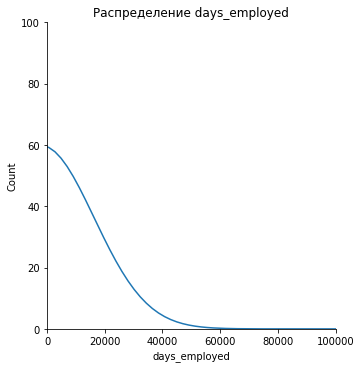

In [ ]:
sns.displot(
  data=data['days_employed'],
  kde=True,
  common_norm=False)

plt.xlim(0, 100000)
plt.ylim(0, 100)
plt.title('Распределение days_employed');

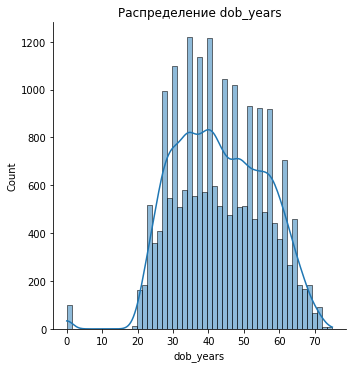

In [ ]:
sns.displot(
  data=data['dob_years'],
  kde=True,
  common_norm=False)

plt.title('Распределение dob_years');

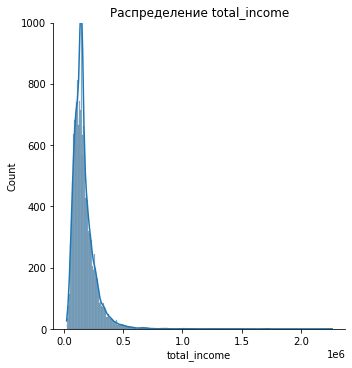

In [ ]:
sns.displot(
  data=data['total_income'],
  kde=True,
  common_norm=False)

plt.ylim(0, 1000)
plt.title('Распределение total_income');

В принципе, графики уже дают примерное представление о том, как нужно разбивать признаки. Наверное, здесь нет какого-то общего рецепта, так что реализуем самый простой вариант - выделим категории "мало", "средне" и "много" для этих признаков

In [ ]:
def get_category(x, min_, avg_first, avg_second):
    if (x > min_) & (x < avg_first):
        return 'мало'
    elif (x > avg_first) & (x < avg_second):
        return 'средне'
    else:
        return 'много'

In [ ]:
data['days_employed_cat'] = data['days_employed'].map(lambda x:
                                                      get_category(x, data['days_employed'].min(), 20000, 40000))

data['days_employed_cat']

0         мало
1         мало
2         мало
3         мало
4        много
         ...  
21520     мало
21521    много
21522     мало
21523     мало
21524     мало
Name: days_employed_cat, Length: 21525, dtype: object

In [ ]:
data['dob_years_cat'] = data['dob_years'].map(lambda x:
                                          get_category(x, data['dob_years'].min(), 30, 60))

data['dob_years_cat']

0        средне
1        средне
2        средне
3        средне
4        средне
          ...  
21520    средне
21521     много
21522    средне
21523    средне
21524    средне
Name: dob_years_cat, Length: 21525, dtype: object

In [ ]:
data['total_income_cat'] = data['total_income'].map(lambda x:
                                                      get_category(x, data['total_income'].min(), 0.2e-6, 0.4e-6))

data['total_income_cat']

0        много
1        много
2        много
3        много
4        много
         ...  
21520    много
21521    много
21522    много
21523    много
21524    много
Name: total_income_cat, Length: 21525, dtype: object

## Значения, не отражающие действительность

Выведем статистики числовых столбцов

In [ ]:
data.describe()

,children,days_employed,dob_years,debt,total_income,жильё,автомобиль,образование,свадьба,операция,семья,недвижимость,строительство,сделка,ремонт
count,21525.000000,21525.000000,21525.000000,21525.000000,2.152500e+04,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000
mean,0.538908,56557.661649,43.293380,0.080883,1.651589e+05,0.207805,0.200465,0.186852,0.109082,0.121254,0.029779,0.295796,0.087387,0.043856,0.028432
std,1.381587,134921.959082,12.574584,0.272661,9.786608e+04,0.405746,0.400357,0.389802,0.311750,0.326430,0.169982,0.456410,0.282408,0.204779,0.166208
min,-1.000000,-18388.000000,0.000000,0.000000,2.066700e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-2518.000000,33.000000,0.000000,1.077980e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1203.000000,42.000000,0.000000,1.450170e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,-385.000000,53.000000,0.000000,1.955430e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,20.000000,401755.000000,75.000000,1.000000,2.265604e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Можно выделить странные значения число детей -1 и отрицательное количество дней в days_employed. Вообще, число дней трудового стажа выглядит как вычисляемое поле. Т.е. независимо от метода сбора данных, вряд ли откуда-то напрямую будет поступать точное число дней - скорее, это какая-нибудь сумма разностей между датами. Отрицательные значения говорят о том, что эта сумма вычислена неправильно, откуда появляются подозрения, что весь признак шумовой 

Наиболее критичным это может оказаться для моделей вроде knn, в которых метрика вычисляется на основе всех признаков или случайного леса, в котором принято строить глубокие деревья; регрессия же просто не будет давать признаку большой вес, а в бустингах неглубокие деревья до него не дойдут

Посмотрим, сколько вообще отрицательных значений в этих признаках

In [ ]:
data[(data[['days_employed']] < 0).all(1)].shape

(18080, 22)

In [ ]:
data[(data[['children']] < 0).all(1)].shape

(47, 22)

Видим, что в children отрицательных значений не очень много, но очень много их в days_employed. Этот, признак можно удалить. С children всё зависит от масштаба ошибки - вычисления это или люди так заполняли или -1 это вообще флаг, который в анкете что-то означал. Но т.к. строк мало и сильно мы ничего не испортим, можем просто удалить отриц. строки

In [ ]:
data = data[((data['children'] > 0) | (data['children'] == 0))]
data.shape

(21478, 22)

In [ ]:
del data['days_employed']

Посмотрим на финальную версию датасета

In [ ]:
data.head()

,children,dob_years,education,family_status,gender,income_type,debt,total_income,жильё,автомобиль,...,свадьба,операция,семья,недвижимость,строительство,сделка,ремонт,days_employed_cat,dob_years_cat,total_income_cat
0,1,42,высокий,женат / замужем,F,сотрудник,0,253875,1,0,...,0,0,0,0,0,0,0,мало,средне,много
1,1,36,средний,женат / замужем,F,сотрудник,0,112080,0,1,...,0,0,0,0,0,0,0,мало,средне,много
2,0,33,средний,женат / замужем,M,сотрудник,0,145885,1,0,...,0,0,0,0,0,0,0,мало,средне,много
3,3,32,средний,женат / замужем,M,сотрудник,0,267628,0,0,...,0,0,0,0,0,0,0,мало,средне,много
4,0,53,средний,гражданский брак,F,пенсионер,0,158616,0,0,...,1,0,0,0,0,0,0,много,средне,много


# Анализ влияния различных параметров на target

## Связь между наличием детей/возвратом кредита в срок

Нам понадобится бинарный признак, показывающий, есть ли дети.

In [ ]:
data['children_binary'] = data['children'].map(lambda x: 1 if x > 0 else 0)
data['children_binary']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0        1
1        1
2        0
3        1
4        0
        ..
21520    1
21521    0
21522    1
21523    1
21524    1
Name: children_binary, Length: 21478, dtype: int64

Таким образом, у нас есть два бинарных признака. В терминах статистики нам нужно сравнить две выборки target в разрезе children_binary. Пусть каждое значение target является реализацией биномиальной СВ с n=1 и неизвестной вероятностью успеха p

Сформируем выборки


In [ ]:
x = np.array(data[data['children_binary'] == 0]['debt'])
x

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y = np.array(data[data['children_binary'] == 1]['debt'])
y

array([0, 0, 0, ..., 1, 1, 0])

Будем использовать точный тест Фишера. Составим таблицу 2х2

In [ ]:
data_ = [[len(x[x == 0]), len(x[x == 1])],
        [len(y[y == 0]), len(y[y == 1])]]
data_

[[13086, 1063], [6652, 677]]

Применим тест

In [ ]:
from scipy.stats import  fisher_exact

print(fisher_exact(data_))

(1.2528817396390592, 1.3379965823263666e-05)


p-value - второе возвращаемое значение. Видим, что мы получили какую-то очень экстремальную таблицу для ситуации, в которой переменные независимы. Глазами это не очень очевидно (соотношение градаций target для первой группы (нет детей) составляет х12, а для второй - х9), но в принципе, учитывая, что мы имеем 20 000 строк, возможно, проценты должны быть гораздо ближе к друг другу при независимости

Пусть уровень значимости равен 0.05, тогда принимаем гипотезу о том, что переменные связаны, а именно, что те, кто имеет детей, чаще оказываются плохими клиентами. Проверялась двусторонняя гипотеза, но по выборке мы видим, в каком хвосте находится p-value



## Связь между семейным положением/возвратом кредита в срок

Посмотрим ещё раз на статусы

In [ ]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдовый',
       'в развод', 'не женат / не замужем'], dtype=object)

Сами слова немного поплыли из-за лемматизации, но это не страшно

Тест Фишера работает не только для бинарных переменных, но и в целом для категориальных, поэтому можем проделать почти аналогичные действия

In [ ]:
x1 = np.array(data[data['family_status'] == 'женат / замужем']['debt'])
x2 = np.array(data[data['family_status'] == 'гражданский брак']['debt'])
x3 = np.array(data[data['family_status'] == 'вдовец / вдовый']['debt'])
x4 = np.array(data[data['family_status'] == 'в развод']['debt'])
x5 = np.array(data[data['family_status'] == 'не женат / не замужем']['debt'])

In [ ]:
data_2 = [[len(x1[x1 == 0]), len(x1[x1 == 1])],
        [len(x2[x2 == 0]), len(x2[x2 == 1])],
        [len(x3[x3 == 0]), len(x3[x3 == 1])],
        [len(x4[x4 == 0]), len(x4[x4 == 1])],
        [len(x5[x5 == 0]), len(x5[x5 == 1])]]
data_2

[[11421, 930], [3784, 388], [893, 63], [1106, 85], [2534, 274]]

К несчастью, реализация scipy поддерживает только таблицы 2х2, поэтому в качестве простой проверки связи между семейным положением и возвратом кредита в срок найдем коэффициент корреляции пирсона. 

In [ ]:
data['family_status_codes'] = data.family_status.astype('category').cat.codes
pearsonr(data['family_status_codes'], data['debt'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(0.010764232652926744, 0.11468225005941074)

Коэффициент корреляции Пирсона получился менее 0.3, значит связь признака и таргета слабая. Также, поскольку p-значение получилось не меньше α = 0.05, можно сделать вывод, что корреляция не является статистически значимой.

# Влияние цели кредита на возвращение его в срок

Цели для которых был взят кредит:

In [ ]:
unique_vals_sorted

['жильё',
 'автомобиль',
 'образование',
 'свадьба',
 'операция',
 'семья',
 'недвижимость',
 'строительство',
 'сделка',
 'ремонт']

In [ ]:
coef_cor = dict()
for purpose in unique_vals_sorted:
  coef_cor[purpose] = pearsonr(data[purpose], data['debt'])
coef_cor

{'жильё': (-0.022590807832226438, 0.0009296410884686459),
 'автомобиль': (0.022729075191273648, 0.0008645147825667388),
 'образование': (0.019690862891407597, 0.003903190857794004),
 'свадьба': (-0.0022192554564925736, 0.7450133104535211),
 'операция': (-0.003072952318333267, 0.6524742977188062),
 'семья': (-0.006948925805210312, 0.3085144485958217),
 'недвижимость': (-0.01514884255862542, 0.026410774298203425),
 'строительство': (-0.0048710213414412, 0.4753328609643479),
 'сделка': (0.02049184585685991, 0.0026707141237685616),
 'ремонт': (-0.01488180963794546, 0.029184987970128355)}

Судя по полученным коэффициентам Пирсона, цель кредита не влияет на возвращение его в срок, тк ни в одном случае коэффициент не превысил 0.3
